In [61]:
from eqr.epistemic_quantile_regressor import EpistemicQuantileRegressor


In [62]:
import matplotlib.pyplot as plt
import scienceplots
import optuna
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_pinball_loss

##
from sklearn.model_selection import train_test_split

plt.style.use(["science", "notebook", "muted"])
plt.rcParams["text.usetex"] = False


def f(x):
    """The function to predict."""
    return x * np.sin(x)


rng = np.random.RandomState(42)
X = np.atleast_2d(rng.uniform(0, 10.0, size=1000)).T
expected_y = f(X).ravel()

sigma = 0.5 + X.ravel() / 10
noise = rng.lognormal(sigma=sigma) - np.exp(sigma**2 / 2)
y = expected_y + noise


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [63]:
mask = (X_train[:, 0] > 4) & (X_train[:, 0] < 6)
X_train = X_train[~mask]
y_train = y_train[~mask]

mask = (X_test[:, 0] > 4) & (X_test[:, 0] < 6)
X_test = X_test[~mask]
y_test = y_test[~mask]

mask = (X_train[:, 0] > 7) & (X_train[:, 0] < 9)
X_train = X_train[~mask]
y_train = y_train[~mask]

mask = (X_test[:, 0] > 7) & (X_test[:, 0] < 9)
X_test = X_test[~mask]
y_test = y_test[~mask]


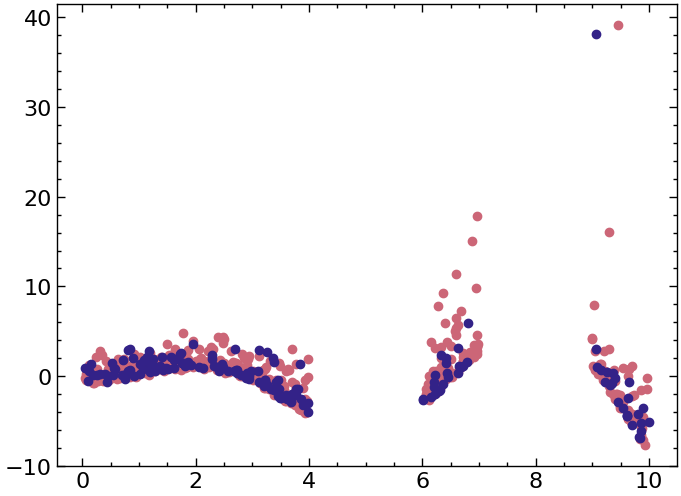

In [64]:
plt.scatter(X_train, y_train)
plt.scatter(X_test, y_test)

In [65]:
alpha=0.95

In [66]:
model = GradientBoostingRegressor(
    loss="quantile",
    alpha=alpha,
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42,
)
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.95, loss='quantile', random_state=42)

In [67]:
mean_pinball_loss(y_test, model.predict(X_test), alpha=alpha)

0.380672104018247

In [68]:
neg_mean_pinball_loss_alpha = make_scorer(
    mean_pinball_loss, alpha=alpha, greater_is_better=False
)


In [69]:
score = -cross_val_score(model, X_train, y_train, cv=3, scoring=neg_mean_pinball_loss_alpha)

In [70]:
score

array([0.24357846, 0.50515505, 0.37791128])

In [71]:
xx = np.linspace(0, 10, 100)[:,np.newaxis]

In [72]:
yhat = model.predict(xx)

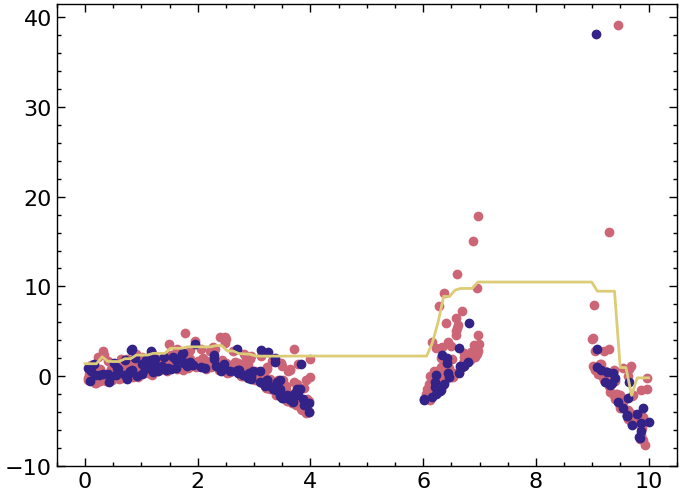

In [73]:
plt.plot(X_train, y_train, 'o')
plt.plot(X_test, y_test, 'o')
plt.plot(xx, yhat)

In [74]:
method = "gbr"
eqr_model = EpistemicQuantileRegressor([(-5, 15)], 2000, method=method)

X_ood, y_ood = eqr_model.generate_synthetic_ood_data(
    X_train,
    y_train,
    scaling_factor=5,
    gm_kwargs={"n_components": 10},
)

X_aug, y_aug = eqr_model.augment_training_data(X_train, y_train, X_ood, y_ood)


print(X_train.shape, X_test.shape, X_ood.shape, X_aug.shape)


(461, 1) (159, 1) (1378, 1) (1839, 1)


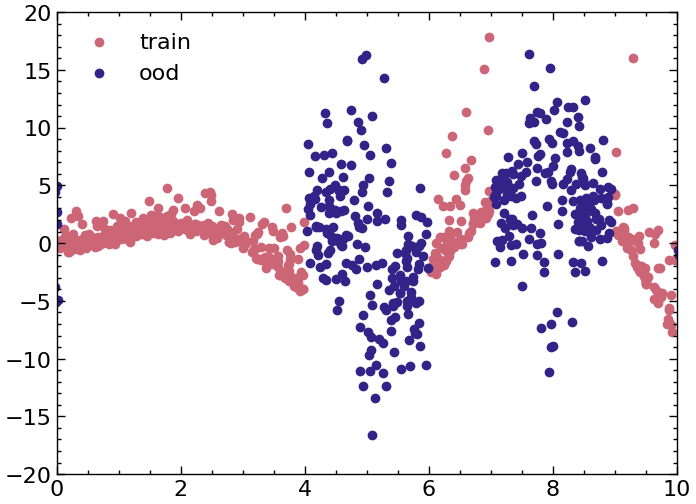

In [75]:
plt.figure()
plt.scatter(X_train, y_train, label="train")
plt.scatter(X_ood, y_ood, label="ood")
plt.legend()
plt.xlim(0, 10)
plt.ylim(-20, 20)
plt.show()

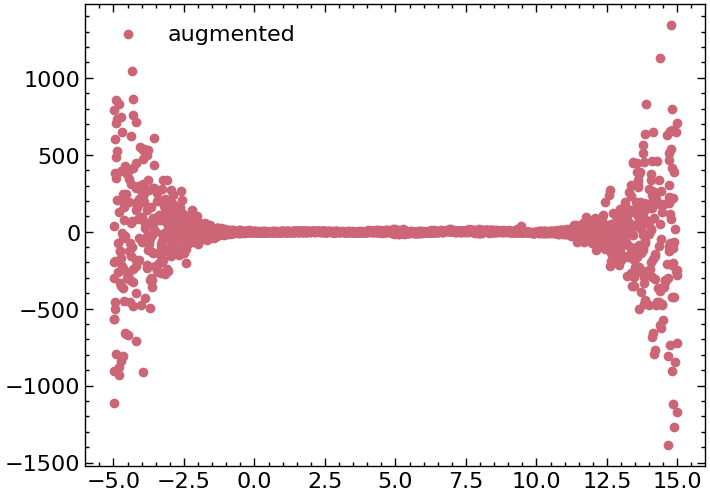

In [76]:

plt.figure()
plt.scatter(X_aug, y_aug, label="augmented")
plt.legend()
plt.show()


# first train on X_train

In [77]:
%%time
if method == "ann":
    params = dict(epochs=1000, batch_size=32)
elif method == "gbr":
    params = dict(n_trials=100)
else:
    raise ValueError(f"unknown {method = }")

eqr_model.fit(X_train, y_train, **params)


  0%|          | 0/100 [00:00<?, ?it/s]

Best hyperparameters: {'n_estimators': 133, 'max_depth': 3, 'learning_rate': 0.19859743127562252}
Best score: 0.11144878533380442


  0%|          | 0/100 [00:00<?, ?it/s]

Best hyperparameters: {'n_estimators': 352, 'max_depth': 3, 'learning_rate': 0.19311863190502968}
Best score: 0.6040879403910525


  0%|          | 0/100 [00:00<?, ?it/s]

Best hyperparameters: {'n_estimators': 93, 'max_depth': 3, 'learning_rate': 0.019969108781987228}
Best score: 0.3569989850984602
CPU times: user 3min 20s, sys: 358 ms, total: 3min 21s
Wall time: 3min 23s


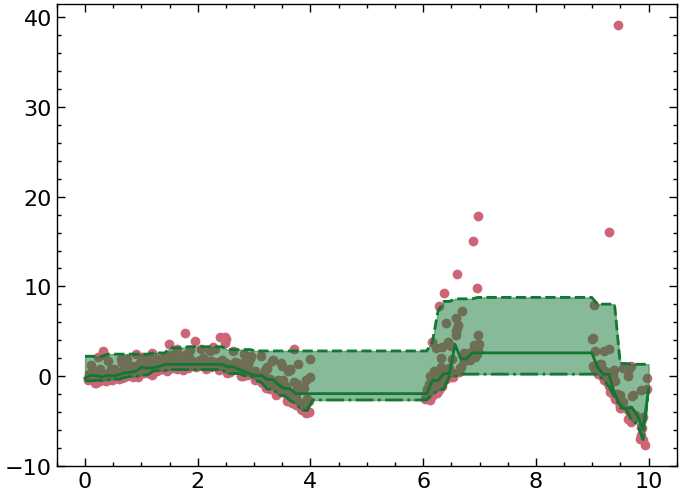

In [78]:
yhats = eqr_model.predict(xx)

plt.figure()
plt.scatter(X_train, y_train, label="train")
# plt.scatter(X_ood, y_ood, label="ood")
plt.plot(xx, yhats[0], c="C3", ls="-.")
plt.plot(xx, yhats[1], c="C3")
plt.plot(xx, yhats[2], c="C3", ls="--")
plt.fill_between(xx[:, 0], yhats[0][:, 0], yhats[2][:, 0], color="C3", alpha=0.5)


# then re-fit the models on X_aug?

In [79]:
eqr_model.models[0.05].fit(X_aug, y_aug)

GradientBoostingRegressor(alpha=0.05, learning_rate=0.19859743127562252,
                          loss='quantile', n_estimators=133, random_state=42)

In [80]:
eqr_model.models[0.5].fit(X_aug, y_aug)

GradientBoostingRegressor(alpha=0.5, learning_rate=0.19311863190502968,
                          loss='quantile', n_estimators=352, random_state=42)

In [81]:
eqr_model.models[0.95].fit(X_aug, y_aug)

GradientBoostingRegressor(alpha=0.95, learning_rate=0.019969108781987228,
                          loss='quantile', n_estimators=93, random_state=42)

(0.0, 10.0)

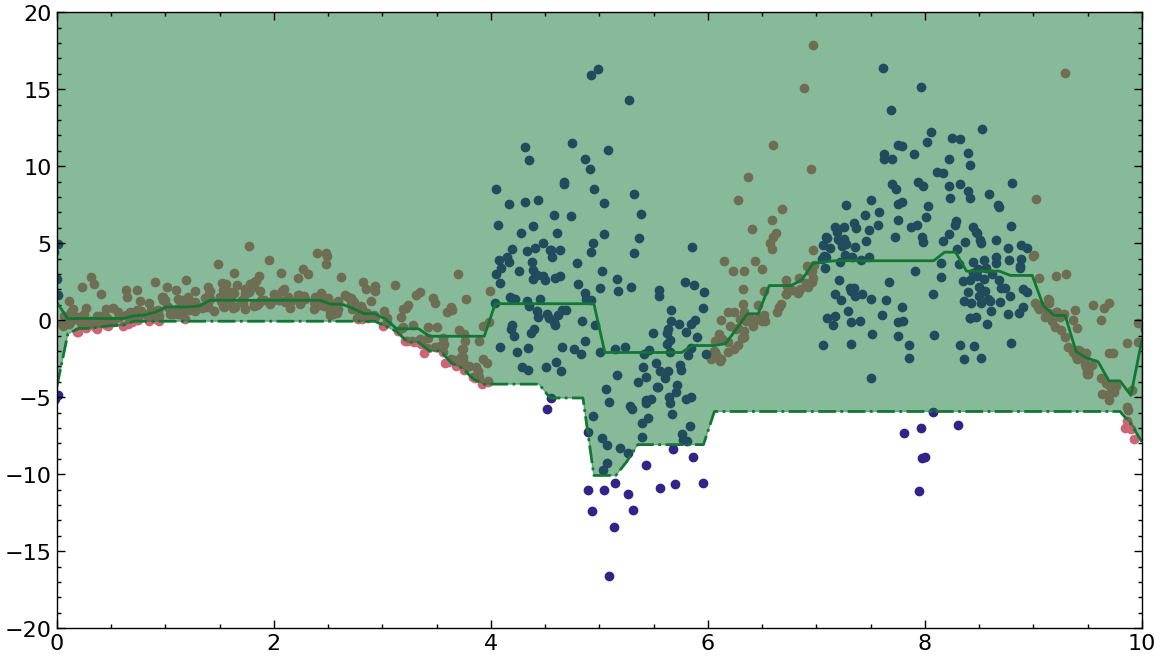

In [82]:
yhats = eqr_model.predict(xx)

plt.figure(figsize=(14, 8))
plt.scatter(X_train, y_train, label="train")
plt.scatter(X_ood, y_ood, label="ood")
plt.plot(xx, yhats[0], c="C3", ls="-.")
plt.plot(xx, yhats[1], c="C3")
plt.plot(xx, yhats[2], c="C3", ls="--")
plt.fill_between(xx[:, 0], yhats[0][:, 0], yhats[2][:, 0], color="C3", alpha=0.5)
plt.ylim(-20, 20)
plt.xlim(0, 10)